In [1]:
import My_functions as Mf
import os
import numpy as np
import matplotlib.pyplot as plt

parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different
save_folder = os.path.join(parent_folder, 'output')
pic_folder = os.path.join(parent_folder, 'Picture', 'alot - PTV')
pic_folder = os.path.join(Mf.select_directory())



frames_per_second = Mf.read_data_from_cihx(pic_folder, return_number = True, return_int=True) # fps
dt = 1/frames_per_second
print('frame per second =', frames_per_second)
print('date of expirement : ', Mf.read_data_from_cihx(pic_folder, '<date>'))
round_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
print(f'Record number - {round_number}')

Mf.create_directory(save_folder)
Mf.copy_file(Mf.files_in_folder(pic_folder, 'cihx', True)[0], save_folder)

c:\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


frame per second = 60
date of expirement :  2023/12/13
Record number - 6


Manual Scaling factor

In [2]:
# if 'scaling_factor_PTV.pkl' in Mf.files_in_folder(save_folder, 'pkl'):
#     scaling_factor = Mf.load_pickle(os.path.join(save_folder, 'scaling_factor_PTV.pkl'))
# else:
#     # lenghght = Mf.pixy().manual_pixel(Mf.find_pictures(pic_folder)[0], keep_same = 'y') #pixel
#     lenghght = Mf.calculate_distance_between_points_napari_notebook_line(Mf.find_pictures(pic_folder)[0], initial_guess = [[368.41, 50.75], [398.41, 50.75]], title='Diameter') #pixel
#     known_lenght = 10/1000 #[m]
#     scaling_factor = lenghght/known_lenght #pixel/m
#     Mf.save_pickle(os.path.join(save_folder,'scaling_factor_PTV.pkl'), scaling_factor)
#     print('ok')
#     print(os.path.join(save_folder,'scaling_factor_PTV.pkl'))

# print('Scaling factor:', scaling_factor, '[pixel/m]')

scaling factor from cihx

In [3]:
unit = Mf.read_data_from_cihx(pic_folder, '<distanceUnit>')
scaling_factor = 1/Mf.read_data_from_cihx(pic_folder, '<sizeOfPixel>', return_number = True) #[pixel/mm]
if 'mm' in unit:
    scaling_factor *= 1000
scaling_factor #[pixel/m]

3012.9557095510695

choose origin

In [4]:
origin = [0, 1024]
# origin = Mf.choose_origin_napari(Mf.find_pictures(pic_folder)[0])

all the files in the directory

In [5]:
sphere_location_pixel = Mf.track_object_series(pic_folder,
												image_number = 637,
												sphere_location = [475, 722],
												Object_data = [[440, 684], [440, 757], [510, 757], [510, 684]],
												PTV_data = [[377, 0], [377, 1022], [610, 1022], [610, 0]])

use arrow keys for fine adjustments, toggle Points visability on and off to see changes 
Select the sphere, the area for PTV and the image number 
important!!! make sure the slider is on the relevant frame 
Change the contrasnt to enable manual high_pass_filter


												image_number = 114,
												sphere_location = [517, 284],
												Object_data = [[481, 251], [481, 324], [551, 324], [551, 251]],
												PTV_data = [[414, 3], [414, 1025], [647, 1025], [647, 3]])


display the sphere with its location

In [6]:
Mf.display_images_with_points_napari(pic_folder, sphere_location_pixel, title = 'Verify sphere location')

801

from pixel to meter

In [7]:
sphere_location_meter = Mf.transform_coordinates_physical(sphere_location_pixel, pic_folder, scaling_factor, origin_point=origin)

skipping photos to get a reasonable velocity plot.

due to oversampling (high frame rate) the velocity uncertainty is biger than 0.1 [m/s] this is unacceptable. thus we skip photos to get a reasonable velocity uncertainty.

0.9968015761
59.808094566


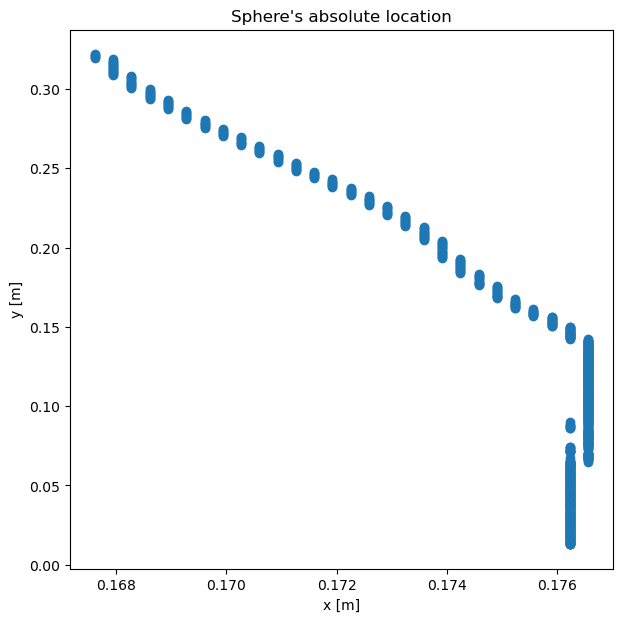

[0.1762389 0.0182545] [0.1762389 0.0129441]
[ 0.        -0.0162631] [ 0.        -0.0159312]
len 14 13
mort 13 13 0.9968015761 the_velocity_error_skipped   0.001


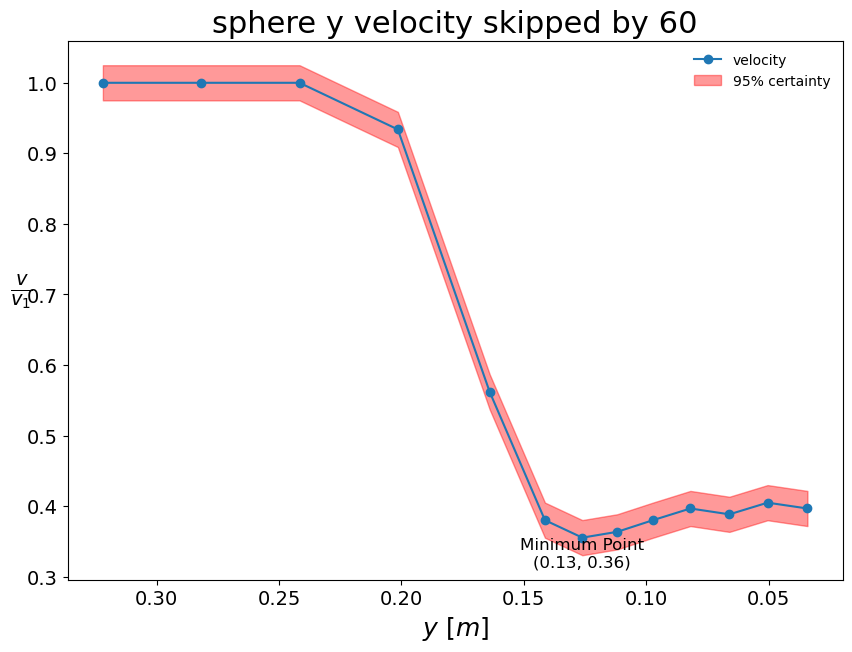

save only


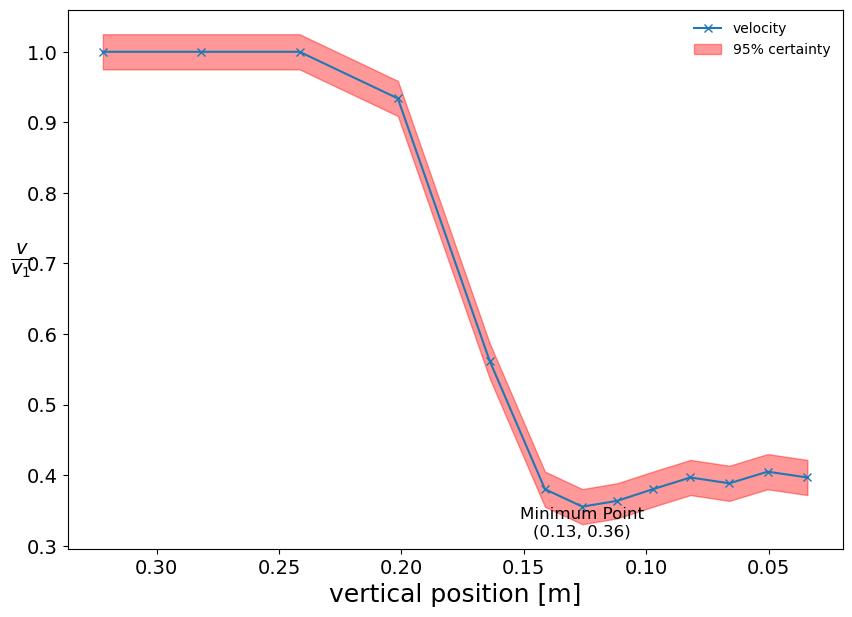

In [8]:
# we sih to find the new dt that corresponds to the wanted velocity uncertainty.
wanted_velocity_uncertainty = 0.001 #[m/s]
scaling_factor_uncertainty = 10 #[pixel/m]
location_uncertainty_pixel = 3 #[pixel]

skipped_dt = Mf.calc_skipped_dt_from_acceptable_error(dt, scaling_factor, 
                                          wanted_velocity_uncertainty, 
                                          scaling_factor_uncertainty, 
                                          location_uncertainty_pixel)

sphere_location_plot = np.array(sphere_location_meter)
x_axis = sphere_location_plot[:, 0]
y_axis = sphere_location_plot[:, 1]

print(skipped_dt)
print(skipped_dt/dt)

#plot location
fig, ax = plt.subplots(figsize=(7,7))
plt.title("Sphere's absolute location")
plt.scatter(x_axis, y_axis)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()



#getting ready for velocity
sphere_location_skipped_meter = Mf.skip_cells(sphere_location_meter, round(skipped_dt/dt), always_include_last = False)

print(sphere_location_skipped_meter[-1], sphere_location_meter[-1])

velocitys_skipped = Mf.calc_velocity_from_skipped_cells(sphere_location_meter, dt, skipped_dt)

print(velocitys_skipped[-2], velocitys_skipped[-1])

print('len',len(sphere_location_skipped_meter), len(velocitys_skipped))




# velocities_y_skipped_meter = velocitys_skipped[:,1]
sphere_location_skipped_plot = np.array(sphere_location_skipped_meter)
sphere_velocity_skipped_plot = np.array(velocitys_skipped)
y_axis_skipped = sphere_location_skipped_plot[:, 1]
y_velocity_skipped = sphere_velocity_skipped_plot[:, 1]

# the_velocity_error_skipped = 1/scaling_factor/skipped_dt #[m/s]

y_err_skipped = np.ones_like(y_velocity_skipped)*wanted_velocity_uncertainty

print('mort', len(y_axis_skipped[:-1]), len(y_velocity_skipped), skipped_dt, 'the_velocity_error_skipped  ', wanted_velocity_uncertainty)




v_1 = min(y_velocity_skipped)
y_velocity_skipped_normalized = y_velocity_skipped/v_1
velocity_acceptable_error_normalized = wanted_velocity_uncertainty/v_1


y_axis_normalized = y_axis_skipped[:-1]

#plot velocity
fig, ax = plt.subplots(figsize=(10, 7))
plt.title("sphere y velocity skipped by "+str(round(skipped_dt/dt)), fontsize = 22)
plt.plot(y_axis_normalized, y_velocity_skipped_normalized,'-o', label='velocity')
plt.fill_between(y_axis_normalized, y_velocity_skipped_normalized + velocity_acceptable_error_normalized,
                  y_velocity_skipped_normalized - velocity_acceptable_error_normalized, color='r', alpha=0.4, label='95% certainty')
# Add text at the minimum point
min_index = np.argmin(y_velocity_skipped_normalized)
plt.text(y_axis_normalized[min_index], y_velocity_skipped_normalized[min_index],
        f'Minimum Point\n({y_axis_normalized[min_index]:.2f}, {y_velocity_skipped_normalized[min_index]:.2f})', 
        horizontalalignment='center', verticalalignment='top', fontsize=12)
plt.xlabel(r'$\mathit{y}\ [m]$', fontsize = 18)
plt.ylabel(r'$\mathit{\frac{v} {v_{1}}}$', fontsize = 20, rotation=0)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.gca().invert_xaxis()
plt.legend(fancybox=True, framealpha=0)
plt.show()



print('save only')
#plot velocity again just for saving fig with no title
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(y_axis_normalized, y_velocity_skipped_normalized,'-x', label='velocity')
plt.fill_between(y_axis_normalized, y_velocity_skipped_normalized + velocity_acceptable_error_normalized,
                  y_velocity_skipped_normalized - velocity_acceptable_error_normalized, color='r', alpha=0.4, label='95% certainty')

# Add text at the minimum point
min_index = np.argmin(y_velocity_skipped_normalized)
plt.text(y_axis_normalized[min_index], y_velocity_skipped_normalized[min_index],
        f'Minimum Point\n({y_axis_normalized[min_index]:.2f}, {y_velocity_skipped_normalized[min_index]:.2f})', 
        horizontalalignment='center', verticalalignment='top', fontsize=12)

plt.xlabel(r'$\mathit{\frac{y} {h}}$', fontsize = 18)
plt.xlabel('vertical position [m]', fontsize = 18)
plt.ylabel(r'$\mathit{\frac{v} {v_{1}}}$', fontsize = 20, rotation=0)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.gca().invert_xaxis()
plt.legend(fancybox=True, framealpha=0)
plt.savefig(os.path.join(save_folder, 'sphere velocity PTV.svg'), transparent=True, bbox_inches='tight')

We skipped alot of pictures, thus we have less data point. the next function fills the missing data points with interplation between pair of points.

In [9]:
sphere_location_skipped_meter = Mf.skip_cells(sphere_location_meter, round(skipped_dt/dt))
# velocitys_skipped = Mf.calc_velocity_from_acceptable_error(sphere_location_meter, scaling_factor, dt, wanted_velocity_uncertainty, scaling_factor_uncertainty, location_uncertainty_pixel)
velocitys_skipped = Mf.calc_velocity_from_skipped_cells(sphere_location_meter, dt, skipped_dt)


y_velocity_skipped_added_point = np.append(velocitys_skipped, [velocitys_skipped[-1]], axis=0)
velocitys_meter = Mf.interpolate_between_points_2d(sphere_location_skipped_meter, y_velocity_skipped_added_point, sphere_location_meter, factor = round(skipped_dt/dt))
if len(velocitys_meter)<len(sphere_location_meter):
    velocitys_meter = np.vstack([velocitys_meter, np.tile(velocitys_meter[-1], (len(sphere_location_meter)-len(velocitys_meter), 1))])
    print(f'The last {len(sphere_location_meter)-len(velocitys_meter)+1:.2f} Point were added to the velocity to match y_axis lenght. thier value is:', velocitys_meter[-1].tolist())

The last 1.00 Point were added to the velocity to match y_axis lenght. thier value is: [0.0, -0.0159312]


Load Data from excel

In [10]:
row_number = 0

In [25]:
experiment_date = Mf.read_data_from_cihx(pic_folder, '<date>')
upper_viscosity, lower_viscosity, upper_density, lower_density, Interface_thickness, sphere_diameter, sphere_rho = Mf.load_data_for_demintionless_number(experiment_date = experiment_date, row_number=row_number)
sphere_type = Mf.extract_data_from_excel(desired_row=Mf.convert_date(experiment_date), data_column='sphere type', Place=row_number)
Interface_height_center = Mf.extract_data_from_excel(desired_row=Mf.convert_date(experiment_date), data_column='relative Interface height [m]')

upper_velocity = -min(velocitys_meter[:,1])
lower_velocity = -velocitys_meter[:,1][-1]

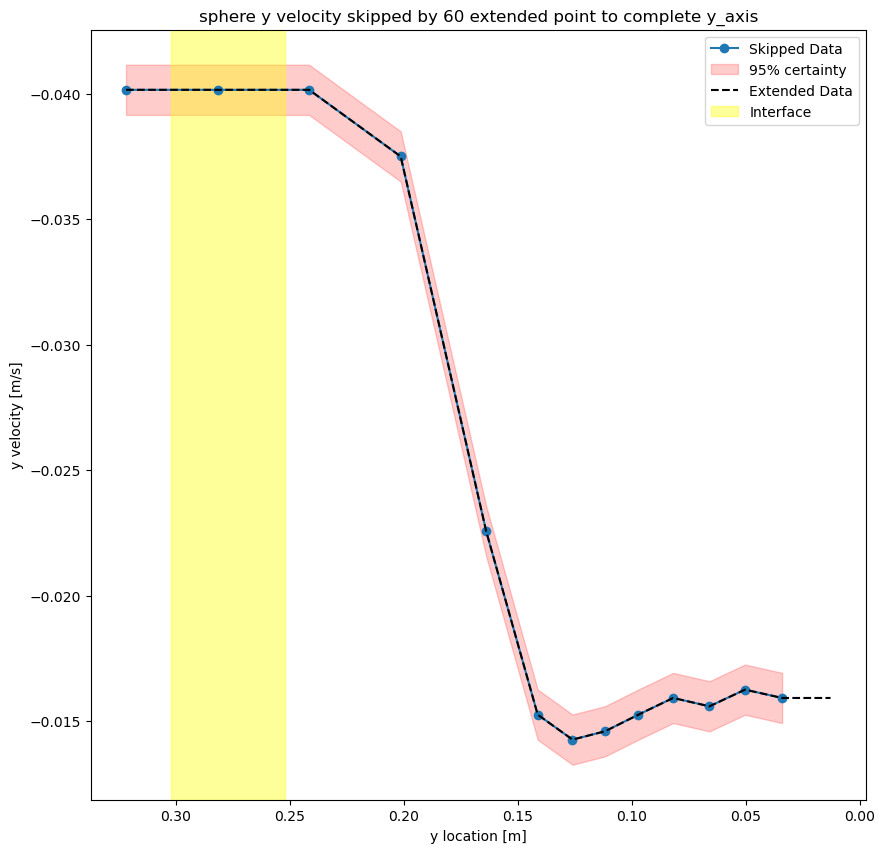

In [27]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(10,10))
plt.title("sphere y velocity skipped by "+str(round(skipped_dt/dt)) + ' extended point to complete y_axis')
plt.plot(y_axis_skipped[:-1], y_velocity_skipped, 'o-', label='Skipped Data')
plt.fill_between(y_axis_skipped[:-1], y_velocity_skipped + wanted_velocity_uncertainty, y_velocity_skipped - wanted_velocity_uncertainty, color='red', alpha=0.2, label='95% certainty')
plt.plot(sphere_location_meter[:,1], velocitys_meter[:,1], '--', color = 'black', label='Extended Data')


# Interface
rect_x = Interface_height_center-Interface_thickness/2 #[m]
rect_width = Interface_thickness
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)



ax.set_xlabel('y location [m]')
ax.set_ylabel('y velocity [m/s]')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [28]:
from scipy.constants import g
upper_Re = upper_velocity*sphere_diameter/upper_viscosity
lower_Re = lower_velocity*sphere_diameter/lower_viscosity
Brunt_number = np.sqrt(2*g/Interface_thickness*(lower_density-upper_density)/(lower_density+upper_density))
upper_Fr = upper_velocity/(Brunt_number*sphere_diameter)
lower_Fr = lower_velocity/(Brunt_number*sphere_diameter)

choosing the state.

In [29]:
if max(velocitys_meter[:,1])*1.1 > velocitys_meter[:,1][-1]:
    state = 'minimum'
    if max(velocitys_meter[:,1]) > 0:
        state = 'bouncing'
else:
    state = 'no - minimum'
print(f'does "{state}" make sense?')

does "minimum" make sense?


In [30]:
run_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
print(f'''experiment_date = {experiment_date}
run_number = {run_number}
sphere_type = {sphere_type}
sphere_diameter = {sphere_diameter}
sphere_rho = {sphere_rho}
upper_density = {upper_density}
lower_density = {lower_density}
upper_viscosity = {upper_viscosity}
lower_viscosity = {lower_viscosity}
upper_Re = {upper_Re}
lower_Re = {lower_Re}
upper_Fr = {upper_Fr}
lower_Fr = {lower_Fr}
Brunt_number = {Brunt_number}
state = {state}''')

experiment_date = 2023/12/13
run_number = 6
sphere_type = P2
sphere_diameter = 0.01
sphere_rho = 1110
upper_density = 1100.0
lower_density = 1108.0
upper_viscosity = 1.4255999999999997e-06
lower_viscosity = 1.5231333333333333e-06
upper_Re = 281.7052469135805
lower_Re = 104.59491399308443
upper_Fr = 3.368657289850139
lower_Fr = 1.3363268587835253
Brunt_number = 1.1921634213430663
state = minimum


# Save
y axis is positive upwards.

+ sphere_location_meter - the sphere aboslute location in meters [m] relative to bottom left corner, the origin.
+ velocitys_meter - sphere velocity in [m/s] SI units


In [31]:
file_path = os.path.join(save_folder, 'data_from_PTV.pkl')
Mf.save_pickle(file_path, [sphere_location_meter, velocitys_meter])

dimensionless_numbers_path = os.path.join(save_folder, 'dimensionless_numbers_PTV.pkl')
Mf.save_pickle(dimensionless_numbers_path, [upper_Re, lower_Re, upper_Fr, lower_Fr, Brunt_number, state])

run_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
dimensionless_numbers_path_excel = os.path.join(parent_folder, 'Dimensionless Numbers PTV.xlsx')

import pandas as pd
import datetime
xls = pd.ExcelFile(dimensionless_numbers_path_excel)
selected_sheet_name = xls.sheet_names[0]
df = pd.read_excel(dimensionless_numbers_path_excel, sheet_name=selected_sheet_name)

new_data = {'Data Processing Date': datetime.date.today().strftime("%Y/%m/%d"), 'Data Processing Hour':datetime.datetime.now().strftime("%H:%M:%S"), 'Experiment Date': experiment_date, 'Record number': run_number, 'Sphere Type':sphere_type,
            'Sphere Diameter [m]':sphere_diameter, 'Sphere density [kg/m^3]':sphere_rho, 'Upper density [kg/m^3]':upper_density,
            'Lower density [kg/m^3]':lower_density, 'Upper viscosity [m^2/sec]':upper_viscosity, 'Lower viscosity [m^2/sec]':lower_viscosity,
            'Upper velocity [m/s]':upper_velocity, 'Lower velocity [m/s]':lower_velocity,'Minimum velocity [m/s]':-max(velocitys_meter[:,1]),
            'Upper Re': upper_Re, 'Lower Re': lower_Re, 'Upper Fr': upper_Fr, 'Lower Fr': lower_Fr, 'Brunt Number': Brunt_number, 'State': state}

df.loc[len(df)] = new_data
df.to_excel(dimensionless_numbers_path_excel, sheet_name=selected_sheet_name, index=False)
xls.close()

print(f'The file {os.path.basename(dimensionless_numbers_path_excel)} has been updated at: {os.path.dirname(dimensionless_numbers_path_excel)}')

The file data_from_PTV.pkl has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output
The file dimensionless_numbers_PTV.pkl has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output
The file Dimensionless Numbers PTV.xlsx has been updated at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis


חלק חדש
אמור לשים את הנקודה במרכז הכדור

In [17]:
# from pprint import pprint
# new_sphere_location = []
# for i in range(len(sphere_location)):
#     new_sphere_location.append(Mf.enhance_coordinates(Mf.find_pictures(pic_folder, True)[i], sphere_location[i], bias = 36))
#     pprint((sphere_location[i][1], new_sphere_location[i][1]))